- Note: ARM pre-interpolated specific humidity was then interpolated to ERA5 pressure levels

In [ ]:
import numpy as np

import os

import xarray as xr

import glob

import matplotlib.pyplot as plt

from metpy.units import units

import datetime

import pandas as pd

import metpy.calc as mpcalc

from matplotlib.colors import BoundaryNorm

import matplotlib.colors as mcolors

import dask.array as da

import pickle

import cartopy.crs as ccrs

import cartopy.feature as cfeature

from scipy.stats import pearsonr

pd.set_option('mode.chained_assignment', None)

In [2]:
# reading in ERA5 pressure for use in plots

base_path = '/data/rong4/Data/ERA5/3hourly/quvw_US'

# Define the range of years and months
years = [str(year) for year in range(2001, 2002)]

def get_files(folder, component):

    files = glob.glob(os.path.join(base_path, folder, f"era5.{component}.*.nc"))

    filtered_files = [f for f in files if any(year in f for year in years)]
    
    return filtered_files

q_files = get_files('specific_humidity', 'specific_humidity')

era5 = xr.open_mfdataset(q_files, combine='by_coords')

In [3]:
p_era = era5['level'].data

mask = (p_era >= 200) & (p_era <= 950)

p_era = p_era[mask]

In [4]:
base_path = '/data/rong3/annie'

file_name = 'q_comparison_stats.csv'

full_path = f"{base_path}/{file_name}"

qcompare = pd.read_csv(full_path)

In [5]:
qcompare['ARM_time'] = pd.to_datetime(qcompare['ARM_time'])

qcompare['ERA_time'] = pd.to_datetime(qcompare['ERA_time'])

# filter rows where the year is less than 2019

qcomp = qcompare[qcompare['ARM_time'].dt.year < 2019]

In [6]:
time_differences = (qcomp['ERA_time'] - qcomp['ARM_time']).dt.total_seconds() / 60

time_differences_list = time_differences.tolist()

In [7]:
qcomp['time_diff'] = (np.abs(qcomp['ERA_time'] - qcomp['ARM_time'])).dt.total_seconds() / 60

# keeping only values within one hour time difference of radiosonde launch and ERA5 timestamp

qdf = qcomp[qcomp['time_diff'] <= 60]

# sorted_qcomp = qcomp.sort_values(by='time_diff', ascending=False)

# qcomp.shape[0]-qdf.shape[0] reveals there were 58 cases exceeding one hour time difference

In [8]:
def convert_to_array(input_string):
    
    input_string = input_string.replace('\n', ' ').strip('[]')  # Clean the string
    
    return np.fromstring(input_string, sep=' ')  # Convert to NumPy array

# Apply the conversion to both 'ERA_q' and 'ARM_q' columns

qdf['ERA_q'] = qdf['ERA_q'].apply(convert_to_array)

qdf['ARM_q'] = qdf['ARM_q'].apply(convert_to_array)

In [9]:
mask_decreasing_q = qdf['ARM_q'].apply(lambda x: x[0] <= x[-1])

mask_toa_q = qdf['ARM_q'].apply(lambda x: x[0] < 2)

mask_mae = qdf['MAE'] <= 3.258

# Combine masks and filter the DataFrame
finalqdf = qdf[mask_decreasing_q & mask_toa_q & mask_mae].copy()

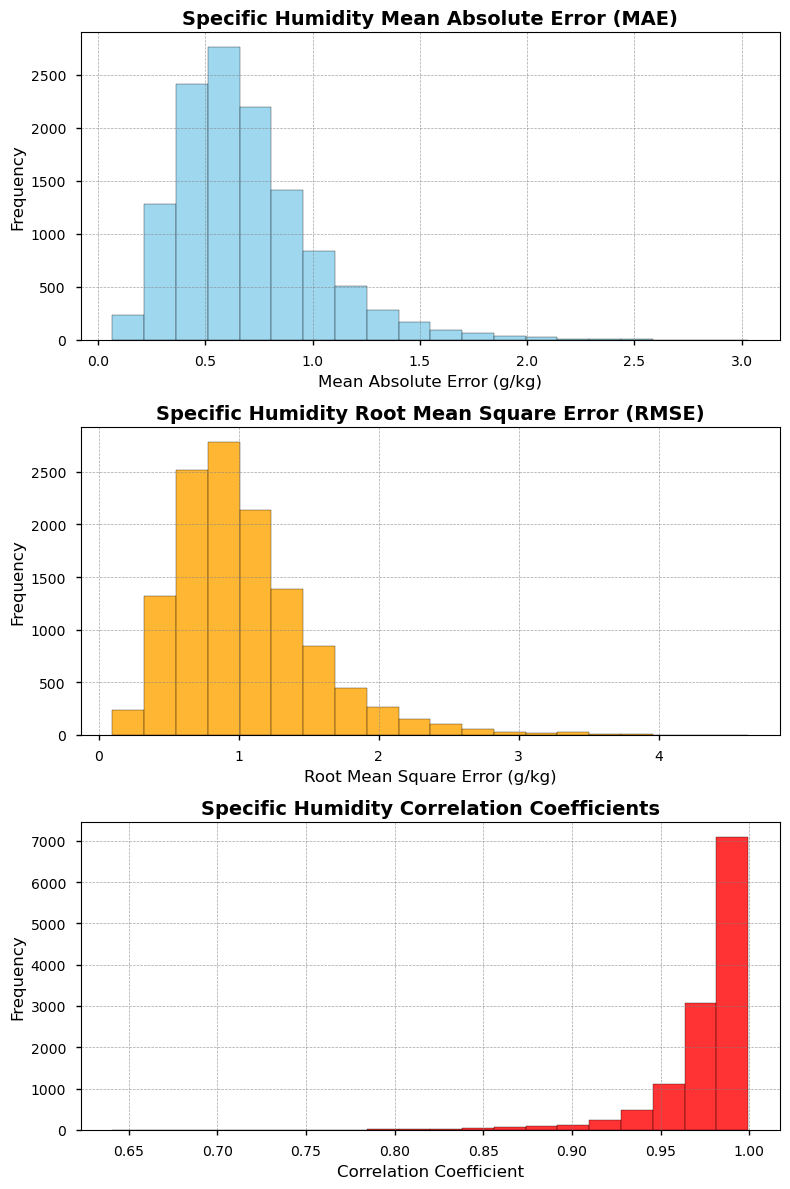

In [10]:
plt.style.use('seaborn-v0_8-notebook')

# Set a consistent number of bins
bins = 20

# Create subplots for better organization
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharey=False)

# MAE Histogram
axes[0].hist(finalqdf['MAE'], color='skyblue', bins=bins, edgecolor='black', alpha=0.8)

axes[0].set_title('Specific Humidity Mean Absolute Error (MAE)', fontsize=14, fontweight='bold')

axes[0].set_xlabel('Mean Absolute Error (g/kg)', fontsize=12)

axes[0].set_ylabel('Frequency', fontsize=12)

axes[0].grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)

# RMSE Histogram
axes[1].hist(finalqdf['RMSE'], color='orange', bins=bins, edgecolor='black', alpha=0.8)

axes[1].set_title('Specific Humidity Root Mean Square Error (RMSE)', fontsize=14, fontweight='bold')

axes[1].set_xlabel('Root Mean Square Error (g/kg)', fontsize=12)

axes[1].set_ylabel('Frequency', fontsize=12)

axes[1].grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)

# Correlation Histogram

axes[2].hist(finalqdf['Correlation'], color='red', bins=bins, edgecolor='black', alpha=0.8)

axes[2].set_title('Specific Humidity Correlation Coefficients', fontsize=14, fontweight='bold')

axes[2].set_xlabel('Correlation Coefficient', fontsize=12)

axes[2].set_ylabel('Frequency', fontsize=12)

axes[2].grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust spacing
plt.tight_layout()

# Show plot
plt.show()

In [32]:
finalqdf['hour'] = finalqdf['ERA_time'].dt.hour

In [56]:
pre_convection = finalqdf[finalqdf['hour']==12]

pre_convection.shape

(2863, 11)

In [57]:
# model - observations (era - arm)

pre_convection['prof_diff'] = pre_convection.apply(lambda row: row['ERA_q'] - row['ARM_q'], axis=1)

average_prof_diff = np.mean(np.vstack(pre_convection['prof_diff']), axis=0)

median_prof_diff = np.median(np.vstack(pre_convection['prof_diff']), axis=0)

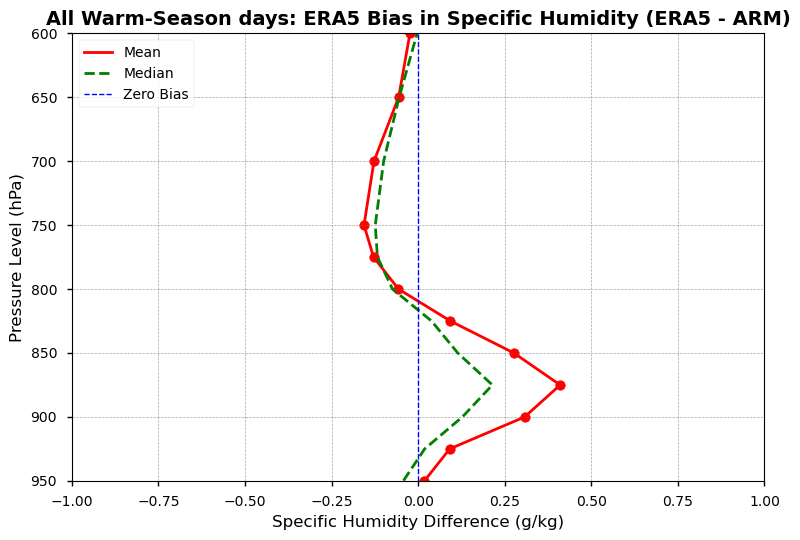

In [58]:
plt.style.use('seaborn-v0_8-notebook')

# Plotting the mean and median
plt.plot(average_prof_diff, p_era, color='red', label='Mean', linewidth=2)
plt.scatter(average_prof_diff, p_era, color='red')

plt.plot(median_prof_diff, p_era, color='green', label='Median', linestyle='--', linewidth=2)

# Zero bias reference line
plt.axvline(x=0, color='blue', linestyle='--', linewidth=1, label='Zero Bias')

# Add gridlines for better readability
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust x-axis and y-axis limits
plt.xlim(-1, 1)
plt.ylim(950, 600)  # Ensure the y-axis is inverted

# Axis labels and title
plt.xlabel("Specific Humidity Difference (g/kg)", fontsize=12)
plt.ylabel("Pressure Level (hPa)", fontsize=12)
plt.title("All Warm-Season days: ERA5 Bias in Specific Humidity (ERA5 - ARM)", fontsize=14, fontweight='bold')

# Add a legend outside the plot
plt.legend(loc='upper left', fontsize=10, frameon=True)

# Show the figure
plt.tight_layout()
plt.show()


In [25]:
# how does average bias differ for hours of the day 

finalqdf['ERA_time'][0]

Timestamp('2001-05-01 00:00:00')

0.9970293550197632


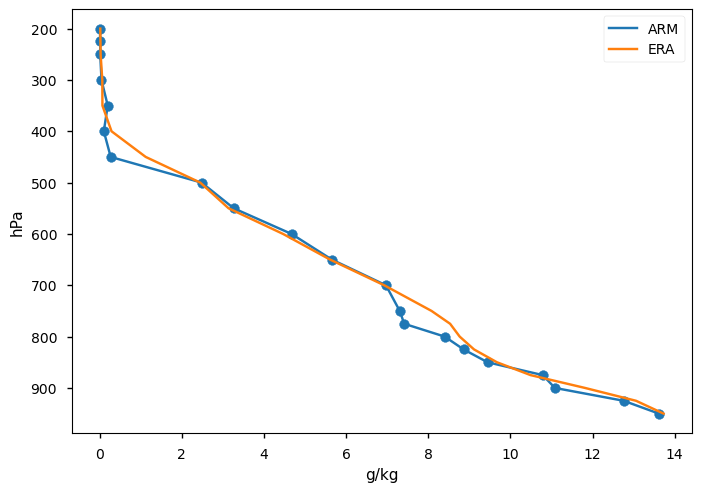

In [27]:
lowcorr = finalqdf.sort_values(by='Correlation').reset_index(drop=True)

index = 12001

print(lowcorr['Correlation'][index])

arm = lowcorr['ARM_q'][index]

era = lowcorr['ERA_q'][index]

plt.plot(arm, p_era, label='ARM')

plt.scatter(arm, p_era)

plt.plot(era, p_era, label='ERA')

plt.gca().invert_yaxis()

plt.legend()

plt.ylabel("hPa")

plt.xlabel("g/kg")

plt.show()

In [ ]:
plt.hist(newqdf['MAE'],bins=20)
plt.show()

In [ ]:
qfilt = qcompare[qcompare['MAE']<5]

qbig = qcompare[(qcompare['MAE']<500) &(qcompare['MAE']>5)]

qcompare.shape[0]-qfilt.shape[0]

In [ ]:
plt.hist(qbig['MAE'], bins=20)
plt.show()

In [ ]:
# 1) calculate mean average error for each time step

# 2) calculate RMSE for each time step 

# 2) calculate correlation coefficient  

In [ ]:
# # reading in ERA5 to compare

# cf = (36.60, -97.48)

# base_path = '/data/rong4/Data/ERA5/3hourly/quvw_US'

# # Define the range of years and months
# years = [str(year) for year in range(2001, 2019)]

# def get_files(folder, component):

#     files = glob.glob(os.path.join(base_path, folder, f"era5.{component}.*.nc"))

#     filtered_files = [f for f in files if any(year in f for year in years)]
    
#     return filtered_files

# q_files = get_files('specific_humidity', 'specific_humidity')

# era5 = xr.open_mfdataset(q_files, combine='by_coords')

# era5cf = era5.sel(latitude=slice(36.75, 36.5), longitude=-97.5)

# era5cf = era5cf.where(era5cf['time.month'].isin(range(5, 10)), drop=True)

# era5cf['time'] = era5cf['time'] - pd.Timedelta(hours=6)

# era5cf = era5cf.sel(time=slice("2001-05-01", "2019-9-30"))

In [ ]:
# # reading in ARM to compare

# directory_path = "../../data/rong1/climate_fu/Data/DOEARM/sgp/sondewnpn"

# # Create a list of file paths

# files = [
    
#     os.path.join(directory_path, file)
    
#     for file in os.listdir(directory_path)
    
#     if file.endswith(".cdf")
# ]

# # filter the files based on year and month criteria

# filtered_files = [
    
#     file for file in files
    
#     if (
        
#         5 <= int(os.path.basename(file).split('.')[2][4:6]) <= 9 and
        
#         2000 < int(os.path.basename(file).split('.')[2][0:4]) < 2020
#     )
# ]

# filtered_files = sorted(filtered_files)

In [ ]:
# def time_adjustment(file):
    
#     bt = pd.to_datetime(file.variables["base_time"].data)
    
#     t = file.coords["time"].data[0]
    
#     t_off = file.variables["time_offset"].data[0]
    
#     bt = pd.Timestamp(bt)
    
#     t_off = pd.Timestamp(t_off)
    
#     yr = bt.year
    
#     month = bt.month
    
#     day = bt.day
    
#     if bt.hour == 0 and bt.minute == 0 and bt.second == 0:
        
#         hr = t_off.hour
        
#         minute = t_off.minute
        
#         second = t_off.second
    
#     else:
        
#         hr = bt.hour
        
#         minute = bt.minute
        
#         second = bt.second
    
#     time_final = (yr, month, day, hr, minute, second)
    
#     time_final = datetime.datetime(*time_final)
    
#     return(time_final)


# def q_calc(pres, dp):
    
#     q_list = []
    
#     length = pres.shape[0]

#     for i in range(length):
        
#         i_pres = pres[i] * units.hPa
        
#         i_dp = dp[i] * units.degC
        
#         q = mpcalc.specific_humidity_from_dewpoint(i_pres, i_dp).to('g/kg')
        
#         q_list.append(q.magnitude)
        
#     return np.array(q_list)

radiosondes launch at: 11:30 PM (5:30 GMT), 5:30 AM (11:30 GMT), (sometimes) 11:30 AM (17:30 GMT), (sometimes) 2:30 PM (20:30 GMT), 5:30 PM (23:30 GMT)

ERA5 has observations at: 12:00 AM, 3 AM, 6 AM, 9 AM, 12 PM, 3 PM, 6 PM 

can compare then: 

- 11:30 PM & 12:00 AM
- 5:30 AM & 6:00 AM 
- 11:30 AM & 12:00 PM
- 2:30 PM & 3:00 PM
- 5:30 PM & 6:00 PM

## loop through each ARM file, compare to associated ERA5 file by matching on time, calculate stats on comparison of q from ARM and q from ERA  

In [ ]:
# comparison_stats = []

# errors = []

# for file in range(len(filtered_files)):
    
#     print("index:", file)

#     arm = xr.open_dataset(filtered_files[file])

#     t_arm = time_adjustment(arm) - datetime.timedelta(hours=6)

#     p_arm = arm['pres'].data

#     dp_arm = arm['dp'].data

#     # finding closest associated time in ERA5 to ARM

#     target_time_np = np.datetime64(t_arm)

#     time_diff = np.abs(era5cf['time'].data - target_time_np)

#     time_era5_index = np.argmin(time_diff)

#     # subsetting ERA5 

#     time_idx = time_era5_index

#     lat_idx = 0

#     t_era = era5cf['time'].data[time_idx]

#     p_era = era5cf['level'].data

#     mask = (p_era >= 200) & (p_era <= 950) # hPa

#     q_era = era5cf['q'].isel(time=time_idx, latitude=lat_idx).values * 1000

#     p_era = p_era[mask]

#     q_era = q_era[mask]

#     print("ERA time:", t_era)

#     # reversing orders so they all go from top of atmosphere to bottom

#     dp_arm_interp = np.interp(p_era, p_arm[::-1], dp_arm[::-1])

#     # calculate ARM q from interpolated dewpoint

#     q_arm = q_calc(p_era, dp_arm_interp)
    
#     if np.any(np.isnan(q_arm)) or np.any(np.isnan(q_era)):
    
#         print(f"Skipping due to NaN values in the data.")
        
#         print("")

#     else:
        
#         # statistics
        
#         mae = np.mean(np.abs(q_arm - q_era))
        
#         print(mae)
        
#         print("")
        
#         rmse = np.sqrt(np.mean((q_arm - q_era) ** 2))
    
#         corr, p_value = pearsonr(q_era, q_arm)

#         # Store the comparison statistics
#         diff = np.abs(q_era - q_arm)  
        
#         tup = ((t_era, t_arm, q_arm, q_era, mae, rmse, corr, p_value))
        
#         comparison_stats.append(tup)
    
    
    
# # Convert comparison stats to DataFrame and save
# df = pd.DataFrame(comparison_stats, columns=["ERA_time", "ARM_time", "ARM_q", "ERA_q", "MAE", "RMSE", "Correlation", "p_value"])

# df.to_csv("q_comparison_stats.csv", index=False)

In [ ]:
# which_error = 2

# q_arm = errors[which_error][2]

# q_era = errors[which_error][3]

# p_era = errors[which_error][4]

# plt.plot(q_arm, p_era, label='arm')

# plt.plot(q_era, p_era, label='era5')

# plt.gca().invert_yaxis()

# plt.legend()

# plt.show()

In [ ]:
# plt.plot(dp_arm[::-1], p1, label='ARM Dewpoint', marker='o', linestyle='--', color='blue')

# plt.plot(dp_arm_interp, p2, label='Interpolated Dewpoint', marker='x', linestyle='-', color='red')

# plt.xlabel('Dewpoint (°C)')

# plt.ylabel('Pressure (hPa)')

# plt.gca().invert_yaxis()  # Invert the y-axis for pressure

# plt.title('Comparison of Dewpoint Profiles')

# plt.legend()

# plt.grid()

# plt.show()


In [ ]:
# # Plot ERA5 data

# plt.plot(q_era, p_era, label="ERA5", color="blue")

# # Plot ARM data (with matched pressures)

# plt.plot(q_arm, p_era, label="ARM", color="orange")

# # Set axis properties

# plt.gca().invert_yaxis()

# plt.xlabel("Specific Humidity (g/kg)")

# plt.ylabel("Pressure (hPa)")

# plt.title("Specific Humidity vs. Pressure")

# plt.grid()

# plt.legend()

# plt.show()
